## **Separamos el conjunto de datos de entrenamiento y validación**

In [22]:
# Definimos el directorio del dataset y el JSONL creado en pre-processing
dataset_parent_dir = "./data"

# jsonl_annotations = 'fire_images_png.jsonl'
jsonl_annotations = 'fire_images.jsonl'
print(jsonl_annotations)

fire_images.jsonl


Creamos los archivos JSONL para entrenamiento (train_annotations.jsonl) y validación (validation_annotations.jsonl)

In [23]:
import json
import os

# Definimos los paths de los folders de entrenamiento y validacion ./data/training-mltable-folder
training_mltable_path = os.path.join(dataset_parent_dir, "training-mltable-folder")
validation_mltable_path = os.path.join(dataset_parent_dir, "validation-mltable-folder")

# Creamos los folders: training-mltable-folder y validation-mltable-folder
os.makedirs(training_mltable_path, exist_ok=True)
os.makedirs(validation_mltable_path, exist_ok=True)

# De cada 5 lineas que se lean del dataset original -> 4 lineas iran a training y 1 a validacion
# es decir, de cada 10 samples, 2 iran a validacion y 8 al entrenamiento (20% validation - 80% training)
train_validation_ratio = 5

# Creamos los archivos jsonl para entrenamiento y validacion 
# train_annotations_file = os.path.join(training_mltable_path, "train_annotations_png.jsonl")
train_annotations_file = os.path.join(training_mltable_path, "train_annotations.jsonl")
# validation_annotations_file = os.path.join(validation_mltable_path, "validation_annotations_png.jsonl")
validation_annotations_file = os.path.join(validation_mltable_path, "validation_annotations.jsonl")

# Leemos el archivo JSONL
with open(jsonl_annotations, "r") as annot_f:
    json_lines = annot_f.readlines()

#Abrimos los archivos train_annotations.jsonl y validation_annotations.jsonl para distribuir records del jsonl_annotations (fire_images_png.jsonl)
index = 0
with open(train_annotations_file, "w") as train_f:
    with open(validation_annotations_file, "w") as validation_f:
        for json_line in json_lines:
            if index % train_validation_ratio == 0:
                validation_f.write(json_line)
            else:
                train_f.write(json_line)
            index += 1

**Creamos el MLTable para enviar al job de AutoML**

In [24]:
def create_ml_table_file(filename):
    return (
        "paths:\n"
        "  - file: ./{0}\n"
        "transformations:\n"
        "  - read_json_lines:\n"
        "        encoding: utf8\n"
        "        invalid_lines: error\n"
        "        include_path_column: false\n"
        "  - convert_column_types:\n"
        "      - columns: image_url\n"
        "        column_type: stream_info"
    ).format(filename)

# Este metodo guarda el archivo "MLTable" en el directorio output_path ./data/training-mltable-folder
def save_ml_table_file(output_path, mltable_file_contents):
    with open(os.path.join(output_path, "MLTable"), "w") as f:
        f.write(mltable_file_contents)

# Creamos el train mltable
train_mltable_file_contents = create_ml_table_file(os.path.basename(train_annotations_file))
save_ml_table_file(training_mltable_path, train_mltable_file_contents)
# Creamos el validation mltable
validation_mltable_file_contents = create_ml_table_file(os.path.basename(validation_annotations_file))
save_ml_table_file(validation_mltable_path, validation_mltable_file_contents)

** Creamos los inputs para mandar al job de AutoML**

In [18]:
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml import Input

#Definimos el input de entrenamiento que usa un MLTable y envia su path ./data/training-mltable-folder
my_training_data_input = Input(type=AssetTypes.MLTABLE, path = training_mltable_path)
print(my_training_data_input)

my_validation_data_input = Input(type=AssetTypes.MLTABLE, path = validation_mltable_path)
print(my_validation_data_input)

{'type': 'mltable', 'path': './data/training-mltable-folder'}
{'type': 'mltable', 'path': './data/validation-mltable-folder'}


## **Creamos un cluster**

In [25]:
#Recuperar todo en caso de que la Instance ha sido apagada y estamos trabajando con una maquina diferente
from azure.identity import DefaultAzureCredential
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml import MLClient
from azure.ai.ml import automl
from azure.ai.ml import Input

credential = DefaultAzureCredential()
ml_client = MLClient.from_config(credential)

training_mltable_path = './data/training-mltable-folder'
validation_mltable_path = './data/validation-mltable-folder'

my_training_data_input = Input(type=AssetTypes.MLTABLE, path = training_mltable_path)
print(my_training_data_input)
my_validation_data_input = Input(type=AssetTypes.MLTABLE, path = validation_mltable_path)
print(my_validation_data_input)

Found the config file in: /config.json


{'type': 'mltable', 'path': './data/training-mltable-folder'}
{'type': 'mltable', 'path': './data/validation-mltable-folder'}


**Usando AMLCompute creamos el cluster**  
Ya que el modelo que queremos clasificar será entrenado para Clasificación de Imagenes (fire-image / non-fire-image), necesitamos que el Cluster cuente con GPU. Los clusters de la familia NC cuenta con GPUs pero debemos seleccionar uno que tenga cuota para la suscripción con la que contamos. Si ingresamos al servicio Quotas y filtramos las cuoas de la familia NC podemos notar que solo tenemos Quotas disponibles en las regiones de West Europe y West US. Por ello, creamos un workspace en la región West US y si queremos crear un Cluster manualmente observamos que solo tenemos 4 opciones de Clusters en esa región (no tenemos suficiente quota para usar otros clusters de la familiar NC).  

De esta forma seleccionados el Cluster STANDARD_NC6s_V3 que tiene 6 cores, 112 GB de Ram, si bien el cluster STANDARD_NC12s_V3 tiene más cores, no es necesario usar 10 cores para entrenar el modelo y es importante destacar que el STANDARD_NC6s_V3 tiene una gran capacidad de RAM.  

Para entrenar los modelos podemos indicar que use maximo 4 instancias (de los 6 cores que tiene el cluster), Azure necesita 2 cores para matenimiento y control del software (bootear vCPUs). Los modelos seran entrenados en los cores en paralelo. En cada core se usará el GPU para cargar las imagenes y hacer los procesamientos necesarios para entrenar cada modelo, ya que el GPU nos permite paralelizar operaciones y acelerar el tiempo de ejecución, a comparación de usar solo el CPU.

In [26]:
from azure.ai.ml.entities import AmlCompute
from azure.core.exceptions import ResourceNotFoundError

compute_name = "gpu-cluster-ncs6sv3"
# compute_name = "gpu-cluster-nc18asv3"

try:
    # Verificamos si no existe un cluster en nuestro workspace con el nombre "gpu-cluster-ncs6sv3"
    cluster = ml_client.compute.get(compute_name)
    print("Found existing compute target!")
except Exception:
    compute_config = AmlCompute(
        name=compute_name,
        type="amlcompute",
        size="STANDARD_NC6s_V3",
        # size="Standard_NC8as_T4_v3",
        idle_time_before_scale_down=120,
        min_instances=0,
        max_instances=4
    )
    cluster = ml_client.begin_create_or_update(compute_config).result()

## **Creamos un job**

Definimos el job, donde la metrica primaria será el _accuracy_ la cual será priorizada para decidir qué modelo será el mejor.  
Ya que estamos entrenando un modelo para Computer Vision no es recomendable poner un timeout porque el entrenamiento de estos puede tomar bastante tiempo y se puede ver interrumpidos.


In [27]:
exp_name = 'dl-fire-detection-png'

image_classfication_job = automl.image_classification(
    compute=compute_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
    primary_metric="accuracy",
    tags={"experiment-description": "Job for image classificiation using images with and without fire"},
)

# max_trials -> cuantas veces se entrenará el mismo modelo pero con diferentes parametros
# max_concurrent_trials -> cuantos modelos correran en paralelo
image_classfication_job.set_limits(
    max_trials = 5,
    max_concurrent_trials = 2
)


Enviamos el job a AutoML para que se ejecute. El job que creamos será de tipo image_classfication_job.

In [28]:
returned_job = ml_client.jobs.create_or_update(
    image_classfication_job
) 

print(f"Created job: {returned_job}")

Uploading training-mltable-folder (0.27 MBs): 100%|██████████| 274724/274724 [00:00<00:00, 4372681.73it/s]


Uploading validation-mltable-folder (0.07 MBs): 100%|██████████| 68959/68959 [00:00<00:00, 1225099.68it/s]




Created job: compute: azureml:gpu-cluster-ncs6sv3
creation_context:
  created_at: '2023-10-30T09:27:18.304337+00:00'
  created_by: Mayra Sandoval Velasco
  created_by_type: User
display_name: sharp_celery_xwp06gvvmp
experiment_name: dl-fire-detection-png
id: azureml:/subscriptions/a3ceb55c-eb6c-4fb9-920b-527d0ef94616/resourceGroups/computer-vision-project/providers/Microsoft.MachineLearningServices/workspaces/project-1/jobs/sharp_celery_xwp06gvvmp
limits:
  max_concurrent_trials: 2
  max_trials: 5
  timeout_minutes: 10080
log_verbosity: info
name: sharp_celery_xwp06gvvmp
outputs: {}
primary_metric: accuracy
properties: {}
resources:
  instance_count: 1
  shm_size: 2g
services:
  Studio:
    endpoint: https://ml.azure.com/runs/sharp_celery_xwp06gvvmp?wsid=/subscriptions/a3ceb55c-eb6c-4fb9-920b-527d0ef94616/resourcegroups/computer-vision-project/workspaces/project-1&tid=ddc8f287-036f-4596-8041-509bb07efc8a
  Tracking:
    endpoint: azureml://westus.api.azureml.ms/mlflow/v1.0/subscription

Ya que le ejecución del job es asincrona, podemos recuperar información del mismo usando jobs.stream

In [30]:
ml_client.jobs.stream(returned_job.name)

RunId: sharp_celery_xwp06gvvmp
Web View: https://ml.azure.com/runs/sharp_celery_xwp06gvvmp?wsid=/subscriptions/a3ceb55c-eb6c-4fb9-920b-527d0ef94616/resourcegroups/computer-vision-project/workspaces/project-1

Execution Summary
RunId: sharp_celery_xwp06gvvmp
Web View: https://ml.azure.com/runs/sharp_celery_xwp06gvvmp?wsid=/subscriptions/a3ceb55c-eb6c-4fb9-920b-527d0ef94616/resourcegroups/computer-vision-project/workspaces/project-1



## ** MLflow para recuperar y visualizar información del job**

Usamos MLflow para recuperar el modelo entrenado que dió mejores metricas en la sección anterior

In [31]:
import mlflow

# Indicamos a mlflow_tracking_uri donde se encuentra nuestro workspace (URI del workspace)
MLFLOW_TRACKING_URI = ml_client.workspaces.get(
    name=ml_client.workspace_name
).mlflow_tracking_uri

print(MLFLOW_TRACKING_URI)

azureml://westus.api.azureml.ms/mlflow/v1.0/subscriptions/a3ceb55c-eb6c-4fb9-920b-527d0ef94616/resourceGroups/computer-vision-project/providers/Microsoft.MachineLearningServices/workspaces/project-1


In [32]:
# Creamos un MLCient para interactuar con MLflow
from mlflow.tracking.client import MlflowClient

# Initialize MLFlow client
mlflow_client = MlflowClient()

In [33]:
# El nombre del job se asignó de forma aleatoria y fue motrado por ml_client.jobs.stream
job_name = 'sharp_celery_xwp06gvvmp' #=returned_job.name

# Usamos mlflow_client para recuperar información del job
mlflow_parent_run = mlflow_client.get_run(job_name)

print(mlflow_parent_run)

<Run: data=<RunData: metrics={'AUC_binary': 0.99986,
 'AUC_macro': 0.99986,
 'AUC_micro': 0.9999,
 'AUC_weighted': 0.99986,
 'accuracy': 0.99,
 'accuracy_train': 0.98748,
 'average_precision_score_binary': 0.99959,
 'average_precision_score_macro': 0.99977,
 'average_precision_score_micro': 0.9999,
 'average_precision_score_weighted': 0.99987,
 'f1_score_binary': 0.97959,
 'f1_score_macro': 0.98648,
 'f1_score_micro': 0.99,
 'f1_score_weighted': 0.99,
 'log_loss': 0.01751,
 'log_loss_train': 0.03595,
 'precision_score_binary': 0.97959,
 'precision_score_macro': 0.98648,
 'precision_score_micro': 0.99,
 'precision_score_weighted': 0.99,
 'recall_score_binary': 0.97959,
 'recall_score_macro': 0.98648,
 'recall_score_micro': 0.99,
 'recall_score_weighted': 0.99}, params={}, tags={'automl_best_child_run_id': 'sharp_celery_xwp06gvvmp_HD_0',
 'experiment-description': 'Job for image classificiation using images with '
                           'and without fire',
 'fit_time_000': 'NaN',
 'i

In [37]:
# Recuperamos los tags que tenía el job. Como por ejemplo el tag que definimos: exp-description
print(mlflow_parent_run.data.tags.keys())

# Usamos el tag (key) "automl_best_child_run_id" para obtener el modelo que tuvo mejores resultados 
best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print(f"BEST CHILD RUN ID: {best_child_run_id}")

dict_keys(['experiment-description', 'model_explain_run', 'is_gpu', 'pipeline_id_000', 'score_000', 'predicted_cost_000', 'fit_time_000', 'training_percent_000', 'iteration_000', 'run_preprocessor_000', 'run_algorithm_000', 'automl_best_child_run_id', 'mlflow.rootRunId', 'mlflow.runName', 'mlflow.user'])
BEST CHILD RUN ID: sharp_celery_xwp06gvvmp_HD_0


In [43]:
# Motramos las metricas del mejor modelo
best_run = mlflow_client.get_run(best_child_run_id)
print("BEST CHILD RUN METRICS: ")
best_run.data.metrics

BEST CHILD RUN METRICS: 


{'accuracy_train': 0.98748,
 'log_loss': 0.01751,
 'log_loss_train': 0.03595,
 'precision_score_weighted': 0.99,
 'f1_score_micro': 0.99,
 'precision_score_macro': 0.98648,
 'AUC_micro': 0.9999,
 'AUC_macro': 0.99986,
 'recall_score_binary': 0.97959,
 'average_precision_score_micro': 0.9999,
 'AUC_weighted': 0.99986,
 'recall_score_macro': 0.98648,
 'f1_score_macro': 0.98648,
 'average_precision_score_macro': 0.99977,
 'average_precision_score_binary': 0.99959,
 'precision_score_micro': 0.99,
 'f1_score_binary': 0.97959,
 'accuracy': 0.99,
 'AUC_binary': 0.99986,
 'average_precision_score_weighted': 0.99987,
 'recall_score_weighted': 0.99,
 'precision_score_binary': 0.97959,
 'f1_score_weighted': 0.99,
 'recall_score_micro': 0.99}

AutomML entrenó 5 modelos utilizando el algoritmo "vitb16r224". Probando diferentes parametros.  
El modelo con un accuracy más alto tiene los siguientes hyperparametros:
* learning_rate = 0.0041196668026614106
* training_batch_size = 34
* valid_crop_size = 280
* valid_resize_size = 320
* validation_batch_size = 52
* weight_decay = 3.337223611753537e-05   

El modelo tuvo unas metricas muy altas, con un accuracy de 0,99. Sin embargo, este se debe a que el dataset no es muy grande como se explicó en el notebook data-preprocessing.ipynb

## ** Deployamos el mejor modelo**

Descargamos el artefacto del modelo (archivo listo para ser deployado o puesto en producción, ya sea en Azure o de forma local)

In [44]:
import os
# Creamos el directorio donde se guardará el artifact
local_dir = "./artifact_downloads"
if not os.path.exists(local_dir):
    os.mkdir(local_dir)

In [45]:
# Descargamos el artifact
local_path = mlflow_client.download_artifacts(
    best_run.info.run_id, "outputs", local_dir
)
print(f"Artifacts downloaded in: {local_path}")
print(f"Artifacts: {os.listdir(local_path)}")

/tmp/ipykernel_5990/1840616594.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.download_artifacts`` is deprecated since 2.0. This method will be removed in a future release. Use ``mlflow.artifacts.download_artifacts`` instead.
  local_path = mlflow_client.download_artifacts(


Artifacts downloaded in: /mnt/batch/tasks/shared/LS_root/mounts/clusters/new-notebook-instance/code/Users/velasquito.md/artifact_downloads/outputs
Artifacts: ['conda_env_v_1_0_0.yml', 'generated_code', 'mlflow-model', 'model.pt', 'run_id.txt', 'scoring_file_v_1_0_0.py']


El archivo _python.pkl_ es un archivo binario donde fue guardado el modelo.

In [47]:
# Importamos las librerias necesarias para deployar el modelo en Azure
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
    ProbeSettings,
)

In [57]:
# Definimos el nombre del endpoint. El cual tiene que ser unico, por lo cual usaremos un timestamp

import datetime
online_endpoint_name = "fire-detection-" + datetime.datetime.now().strftime(
    "%m%d%H%M"
)

# Definimos información del endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="Endpoint del modelo deployado",
    auth_mode="key",
    tags={"model": "best model for accuracy"},
)

In [58]:
# Creamos el endpoint
ml_client.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://fire-detection-10301201.westus.inference.ml.azure.com/score', 'openapi_uri': 'https://fire-detection-10301201.westus.inference.ml.azure.com/swagger.json', 'name': 'fire-detection-10301201', 'description': 'Endpoint del modelo deployado', 'tags': {'model': 'best model for accuracy'}, 'properties': {'azureml.onlineendpointid': '/subscriptions/a3ceb55c-eb6c-4fb9-920b-527d0ef94616/resourcegroups/computer-vision-project/providers/microsoft.machinelearningservices/workspaces/project-1/onlineendpoints/fire-detection-10301201', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/a3ceb55c-eb6c-4fb9-920b-527d0ef94616/providers/Microsoft.MachineLearningServices/locations/westus/mfeOperationsStatus/oe:2529274f-eb40-47ee-99d6-bf10bf3c7049:939b938f-922f-46f6-ac2b-8ab0ce0ee306?api-version=2022-02-01-preview'}, 'print_as_yaml': True, 'id': '/subscriptions/a3ceb55c-eb6

Registramos el modelo en la lista de modelos de nuestro workspace

In [50]:
# Definimos el nombre e información del modelo

model_name = "fire-deteciton-model"

model = Model(
    path=f"azureml://jobs/{best_run.info.run_id}/outputs/artifacts/outputs/mlflow-model/",
    name=model_name,
    description="Model that detects fire in images",
    type=AssetTypes.MLFLOW_MODEL,
)

In [51]:
# Creamos el modelo
registered_model = ml_client.models.create_or_update(model)

Deployamos el modelo en el endpoint que creamos (fire-detection-10301201)

In [55]:
from azure.ai.ml.entities import OnlineRequestSettings

# Seteamos un request timeout de 90 segundos
req_timeout = OnlineRequestSettings(request_timeout_ms=90000)

In [59]:
print(online_endpoint_name)

fire-detection-10301201


In [60]:
# Definimos cómo se hará el deployment 

deployment = ManagedOnlineDeployment(
    name="fire-detection-mlflow-deploy",
    endpoint_name=online_endpoint_name,
    model=registered_model.id,
    # use GPU instance type like Standard_NC6s_v3 for faster explanations
    instance_type="Standard_NC6s_v3",
    instance_count=1,
    request_settings=req_timeout
)

In [61]:
ml_client.online_deployments.begin_create_or_update(deployment).result()

Check: endpoint fire-detection-10301201 exists


.............................................................................................................................

ManagedOnlineDeployment({'private_network_connection': None, 'provisioning_state': 'Succeeded', 'endpoint_name': 'fire-detection-10301201', 'type': 'Managed', 'name': 'fire-detection-mlflow-deploy', 'description': None, 'tags': {}, 'properties': {'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/a3ceb55c-eb6c-4fb9-920b-527d0ef94616/providers/Microsoft.MachineLearningServices/locations/westus/mfeOperationsStatus/od:2529274f-eb40-47ee-99d6-bf10bf3c7049:fa93af79-6cd7-43d2-b80c-ed5d34f90391?api-version=2023-04-01-preview'}, 'print_as_yaml': True, 'id': '/subscriptions/a3ceb55c-eb6c-4fb9-920b-527d0ef94616/resourceGroups/computer-vision-project/providers/Microsoft.MachineLearningServices/workspaces/project-1/onlineEndpoints/fire-detection-10301201/deployments/fire-detection-mlflow-deploy', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/new-notebook-instance/code/Users/velasquito.md', 'creation_context': None, 'serialize': <msr

## **Hacemos inferencias enviando requests al endpoint**

#### **Enviamos el request invocando al endpoint desde MLClient (fire-image)**

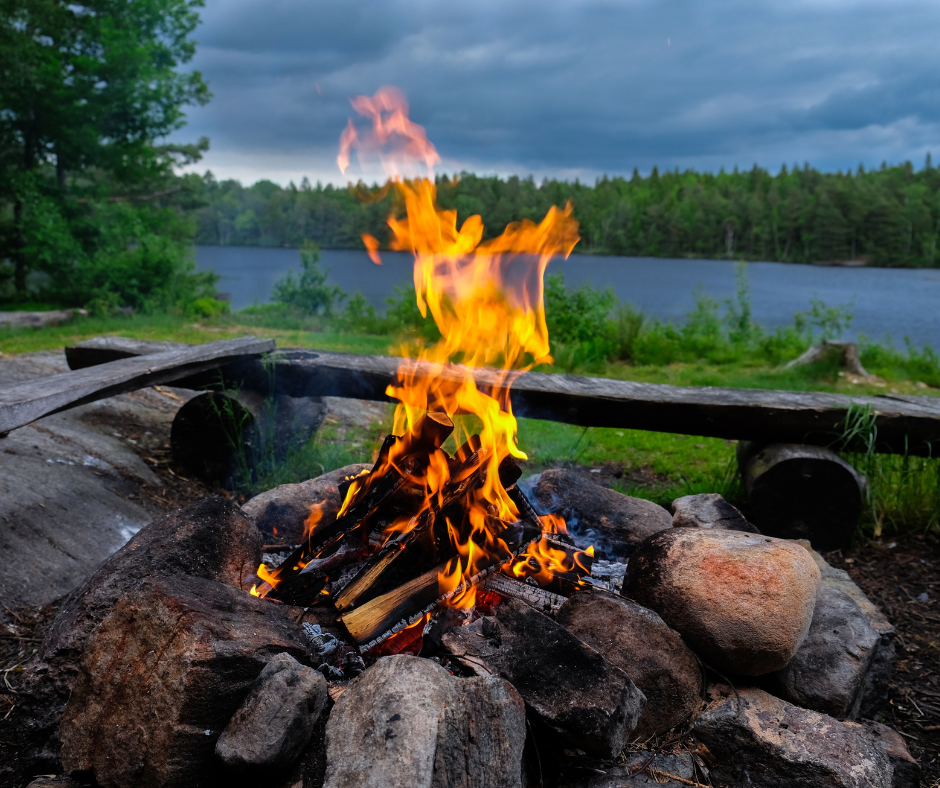

In [65]:
# Mostramos la imagen que usará para hacer la inferencia
from IPython.display import Image
test_fire_image = os.path.join(dataset_parent_dir, "test_images", "test_fire.png") #./data/test_images/test_fire.png
Image(filename=test_fire_image)

In [66]:
import base64

# Funcion para leer imagenes
def read_image(image_path):
    with open(image_path, "rb") as f:
        return f.read()

# Estructura del body del request
request_json = {
    "input_data": {
        "columns": ["image"],
        "data": [base64.encodebytes(read_image(test_fire_image)).decode("utf-8")]
    }
}

In [67]:
import json

#Guardamos el body, que se enviará en el request, en un archivo
request_file_name = "test_fire.json"

with open(request_file_name, "w") as request_file:
    json.dump(request_json, request_file)

In [68]:
resp = ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name=deployment.name,
    request_file=request_file_name,
)
resp

'[{"probs": [0.9983715415000916, 0.0016284543089568615], "labels": ["fire_images", "non_fire_images"]}]'

#### **Enviamos el request invocando al endpoint desde MLClient (non-fire-image)**

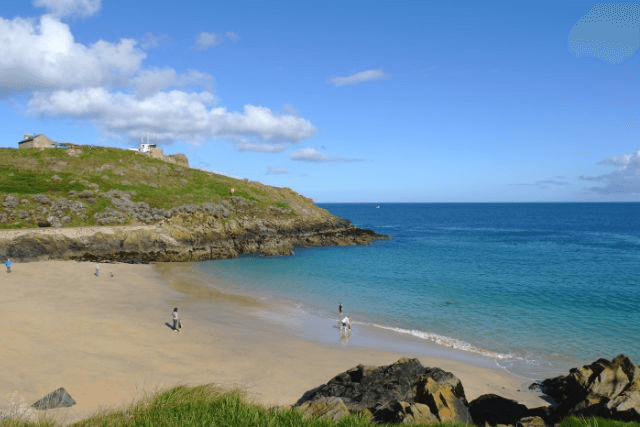

In [91]:
# Mostramos una imagen sin fuego, humo o incendios.
from IPython.display import Image
test_non_fire_image = os.path.join(dataset_parent_dir, "test_images", "test_non_fire.png") #./data/test_images/test_non_fire.png
Image(filename=test_non_fire_image)

In [94]:
# Estructura del body del request
request_json = {
    "input_data": {
        "columns": ["image"],
        "data": [base64.encodebytes(read_image(test_non_fire_image)).decode("utf-8")]
    }
}
#Guardamos el body, que se enviará en el request, en un archivo
request_file_name = "test_non_fire.json"

with open(request_file_name, "w") as request_file:
    json.dump(request_json, request_file)

In [95]:
resp = ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name=deployment.name,
    request_file=request_file_name,
)
resp

'[{"probs": [0.03856640309095383, 0.9614335894584656], "labels": ["fire_images", "non_fire_images"]}]'